# BikewaySim Routing

In [1]:
import sys
from pathlib import Path
import pickle
import pandas as pd
import geopandas as gpd

import src.bikewaysim_functions as bikewaysim_functions

import sys
sys.path.insert(0,str(Path.cwd().parent))
import file_structure_setup
config = file_structure_setup.filepaths()

import impedance_calibration.stochastic_optimization as stochastic_optimization
from network.src import modeling_turns


# Import ODs

In [2]:
# import matched ODS (i.e. already have the correct network nodes)
od_matrix = pd.read_csv(config['bikewaysim_fp']/'od_matrix.csv')
od_matrix


,dest_taz,orig_taz,trips,orig_N,dest_N
0,130510001001004,130510011002033,1,8.918424e+09,8.092881e+09
1,130510001001004,130510027004012,1,5.432307e+09,8.092881e+09
2,130510001001004,130510028001005,1,6.714626e+07,8.092881e+09
3,130510001001004,130510114002000,1,6.714431e+07,8.092881e+09
4,130510001001004,130510116002009,1,6.708073e+07,8.092881e+09
...,...,...,...,...,...
15270,130519800001057,130510116001016,1,7.860268e+09,8.080005e+09
15271,130519800001057,130510116001018,1,8.879344e+09,8.080005e+09
15272,130519800001057,130510116001028,1,7.622715e+09,8.080005e+09
15273,130519800001058,130510033012006,1,6.710322e+07,7.257544e+09


In [3]:
ods = list(set(zip(od_matrix['orig_N'],od_matrix['dest_N'])))


# Select Calibration Results to Get Coefficients

In [4]:
#set calibration results
if bool(config['use_default_calibration']) == True:
    #calibration_result = calibration_results[-1]
    betas = [-0.184, -0.398, 0.126, 0.325, 0.324]#list(calibration_result.values())[0:-3]
    betas_links = {0:'multi use path',1:'bike lane',2:'lanes',3:'above_4'}
    betas_turns = {4:'unsig_major_road_crossing'}
else:
    # import the calibration results
    with (config['calibration_fp']/"calibration_results.pkl").open('rb') as fh:
        calibration_results = pickle.load(fh)

    #BUG saved calibration coefficients are wrong
    calibration_result = calibration_results[-1]
    betas = [-0.184, -0.398, 0.126, 0.325, 0.324]#list(calibration_result.values())[0:-3]
    betas_links = calibration_result['beta_links']
    betas_turns = calibration_result['beta_turns']
    

# Import Network

In [5]:
# import test case/ base case (think of a better word) network
with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)

turn_G = modeling_turns.make_turn_graph(turns)

## Process the improvements

In [6]:
#remove improvements that aren't improvements
links.loc[links['facility_fwd']==links['improvement'],'improvement'] = None
# links.loc[links['improvement'].notna(),['facility_fwd','improvement']]

#change cycletracks to multi use paths for now
change_infra = {
    'buffered bike lane': 'bike lane',
    'cycletrack': 'multi use path'
}
links['improvement'] = links['improvement'].apply(lambda x: change_infra.get(x,x))
links['facility_fwd'] = links['facility_fwd'].apply(lambda x: change_infra.get(x,x))

#combine facilities into one
import numpy as np
links['facility_fwd_new'] = np.where(links['improvement'].notna(),links['improvement'],links['facility_fwd'])

<Axes: >

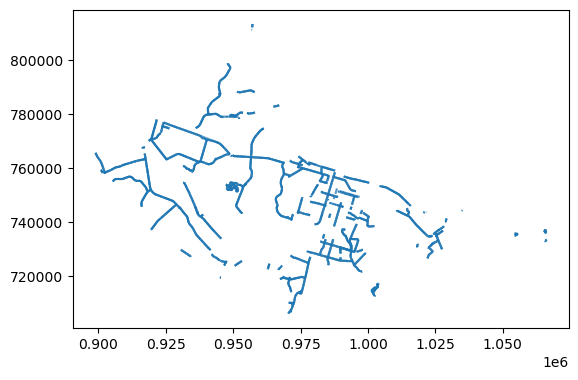

In [7]:
links[links['facility_fwd_new'].notna()].plot()

In [8]:
#TODO fix this by modifying network modifications step 3
facility_ids = gpd.read_file(config['bicycle_facilities_fp']/"network_improvements.gpkg",layer=config['improvement_name'])
facility_ids.rename(columns={'osm_linkid':'linkid'},inplace=True)
facility_ids = facility_ids[[f"{config['improvement_name']}_id",'linkid']]

In [9]:
#import the coa id back in so that we can aggregate by the faciility
#facility_ids = gpd.read_file(config['bicycle_facilities_fp']/"network_improvements.gpkg",layer=config['improvement_name'])[[f"{config['improvement_name']}_id",'linkid']]
improvements = links.loc[links['improvement'].notna()].copy()
improvements = pd.merge(improvements[['linkid','facility_fwd_new','geometry']],facility_ids,on='linkid')
improvements.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='improvements')

In [10]:
improvements_buffer = improvements.copy()
improvements_buffer.geometry = improvements_buffer.buffer(400)
improvements_buffer = improvements_buffer.dissolve([f"{config['improvement_name']}_id",'facility_fwd_new']).reset_index()
improvements_buffer.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='improvements_buffer')

# Travel Time Routing

In [11]:
from importlib import reload
reload(stochastic_optimization)

# run impedance routing on all the provided ODs 170 mins
base_impedance_col = "travel_time_min"
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)


In [12]:
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,links,start_node,end_node) for start_node, end_node in ods}
with (config['bikewaysim_fp']/"current_shortest_results.pkl").open('wb') as fh:
    pickle.dump(results_dict,fh)

# Shortest Path Routing


In [13]:
# create the neccessary attributes for impednaces
links['bike lane'] = (links['facility_fwd'] == 'bike lane').astype(int)
links['multi use path'] = (links['facility_fwd'] == 'multi use path').astype(int)
links.loc[links['multi use path']==1,'lanes'] = 0

In [14]:
from importlib import reload
reload(stochastic_optimization)
 
# run impedance routing on all the provided ODs
base_impedance_col = "travel_time_min"
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

#update impedances
print(betas)
stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
                          stochastic_optimization.link_impedance_function,
                          base_impedance_col,
                          stochastic_optimization.turn_impedance_function,
                          links,turns,turn_G)
current_links = links.copy()

[-0.184, -0.398, 0.126, 0.325, 0.324]


In [15]:
#export the current network
current_links[['linkid','reverse_link','travel_time_min','multiplier','link_cost','geometry']].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='current_network')

In [16]:
#170 minutes
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,links,start_node,end_node) for start_node, end_node in ods}

with (config['bikewaysim_fp']/"current_results.pkl").open('wb') as fh:
    pickle.dump(results_dict,fh)


# Repeat with Network Improvements


In [17]:
#update the bike lane, multi use path, and lanes attributes
links['bike lane'] = (links['facility_fwd_new']=='bike lane').astype(int)
links['multi use path'] = (links['facility_fwd_new']=='multi use path').astype(int)

#for multiuse paths, make sure to set the lanes attribute to zero
links.loc[links['multi use path']==1,'lanes'] = 0

In [18]:
from importlib import reload
reload(stochastic_optimization)

# run impedance routing on all the provided ODs
base_impedance_col = "travel_time_min"
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

#update impedances
#betas = #past_betas[np.array(past_vals).argmin()]#x.x
print(betas)
stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
                          stochastic_optimization.link_impedance_function,
                          base_impedance_col,
                          stochastic_optimization.turn_impedance_function,
                          links,turns,turn_G)
future_links = links.copy()


[-0.184, -0.398, 0.126, 0.325, 0.324]


In [19]:
#export the current network
future_links[['linkid','reverse_link','travel_time_min','multiplier','link_cost','geometry']].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='future_network')

In [20]:
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,links,start_node,end_node) for start_node, end_node in ods}
with (config['bikewaysim_fp']/"future_results.pkl").open('wb') as fh:
    pickle.dump(results_dict,fh)